In [1]:
!pip install mapie -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 88.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.0 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.


In [2]:
pip install lightgbm --install-option=--gpu


Usage:   
  /usr/bin/python3 -m pip install [options] <requirement specifier> [package-index-options] ...
  /usr/bin/python3 -m pip install [options] -r <requirements file> [package-index-options] ...
  /usr/bin/python3 -m pip install [options] [-e] <vcs project url> ...
  /usr/bin/python3 -m pip install [options] [-e] <local project path> ...
  /usr/bin/python3 -m pip install [options] <archive url/path> ...

no such option: --install-option
Note: you may need to restart the kernel to use updated packages.


In [3]:
# --- 0. Import Libraries ---
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from mapie.regression import ConformalizedQuantileRegressor
import warnings
import os

In [4]:
warnings.filterwarnings('ignore')

In [5]:
class CFG:
    # Global settings
    SEED = 42
    N_SPLITS = 5  # Number of folds for cross-validation
    CONFIDENCE_LEVEL = 0.9  # Target confidence level (90%)
    ALPHA = 1 - CONFIDENCE_LEVEL

    # File paths
    try:
        # Kaggle environment
        DATA_PATH = '/kaggle/input/prediction-interval-competition-ii-house-price/'
        if not os.path.exists(os.path.join(DATA_PATH, 'dataset.csv')):
            raise FileNotFoundError
    except FileNotFoundError:
        print("Kaggle path not found or files missing, switching to local path './'.")
        DATA_PATH = './'
    OUTPUT_PATH = './'

    # Base parameters for the quantile models
    LGBM_PARAMS = {
        'objective': 'quantile',
        'metric': 'quantile',
        'n_estimators': 2000, # Increased for early stopping
        'subsample': 0.8,
        'colsample_bytree': 0.5,
        'learning_rate': 0.05,
        'max_depth': -1,
        'min_child_samples': 150,
        'n_jobs': -1,
        'random_state': SEED,
        'verbose': -1,
        'device': 'gpu',
        'max_bin':255,
        'gpu_platform_id': 0, 
        'gpu_device_id': 0,  
    }

In [6]:
def winkler_score_func(y_true, lower, upper, alpha=CFG.ALPHA):
    """Utility function to calculate the Winkler score."""
    score = np.mean(upper - lower)
    score += np.mean(np.where(y_true < lower, (2 / alpha) * (lower - y_true), 0))
    score += np.mean(np.where(y_true > upper, (2 / alpha) * (y_true - upper), 0))
    return score


In [7]:
# --- 2. Data Loading and Preprocessing ---
print("\n--- Phase 1: Loading and Preprocessing Data ---")
try:
    train_df_raw = pd.read_csv(os.path.join(CFG.DATA_PATH, 'dataset.csv'))
    test_df_raw = pd.read_csv(os.path.join(CFG.DATA_PATH, 'test.csv'))
except FileNotFoundError:
    print("Error: dataset.csv or test.csv not found.")
    print("Creating dummy data for demonstration purposes.")
    train_df_raw = pd.DataFrame({
        'id': range(1000), 'sale_price': np.random.rand(1000) * 500000 + 100000,
        'sale_date': pd.to_datetime(pd.date_range(start='2022-01-01', periods=1000)),
        'category_feature': np.random.choice(['A', 'B', 'C'], 1000)
    })
    test_df_raw = pd.DataFrame({
        'id': range(1000, 1200),
        'sale_date': pd.to_datetime(pd.date_range(start='2024-09-01', periods=200)),
        'category_feature': np.random.choice(['A', 'B', 'C'], 200)
    })



--- Phase 1: Loading and Preprocessing Data ---


In [8]:
def feature_engineer(df):
    """Simple feature engineering."""
    data = df.copy()
    if 'sale_date' in data.columns:
        data['sale_date'] = pd.to_datetime(data['sale_date'])
        data['sale_year'] = data['sale_date'].dt.year
        data['sale_month'] = data['sale_date'].dt.month
        data['sale_dayofweek'] = data['sale_date'].dt.dayofweek
        first_sale_month = data['sale_date'].dt.to_period('M').min()
        data['months_since_first_sale'] = (data['sale_date'].dt.to_period('M') - first_sale_month).apply(lambda x: x.n)
        data = data.drop('sale_date', axis=1)
    cat_cols = data.select_dtypes(include=['object']).columns
    for col in cat_cols:
        data[col] = pd.Categorical(data[col])#给特征编码
    return data


In [9]:
def add_interaction_features(
    X: pd.DataFrame,
    use_house_age=True,
    use_reno_age=True,
    use_sqft_times_stories=True,
    use_beds_times_baths=True,
    use_aux_space=True,
    use_density=True,
    use_num_views=True,
    use_scenic_score=True,
    use_env_score=True
) -> pd.DataFrame:
    """
    根据控制开关添加房屋相关交互特征，返回增强后的 DataFrame。
    所有新增特征为 float 类型。
    """

    X = X.copy()

    # 1. 房龄
    if use_house_age:
        X['house_age'] = (X['sale_year'] - X['year_built']).clip(lower=0).astype(float)

    # 2. 装修后房龄
    if use_reno_age:
        reno_age = X['sale_year'] - X['year_reno']
        house_age = X.get('house_age', (X['sale_year'] - X['year_built']).clip(lower=0))
        X['reno_age'] = pd.Series(np.where(X['year_reno'].isna(), house_age, reno_age), index=X.index).clip(lower=0).astype(float)

    # 3. 面积 × 楼层数
    if use_sqft_times_stories:
        X['sqft_times_stories'] = (X['sqft'] * X['stories']).astype(float)

    # 4. 卫浴数 × 卧室数
    if use_beds_times_baths:
        X['total_baths'] = (
            X.get('bath_full', 0) +
            X.get('bath_3qtr', 0) * 0.75 +
            X.get('bath_half', 0) * 0.5
        ).astype(float)
        X['beds_times_baths'] = (X['beds'] * X['total_baths']).astype(float)

    # 5. 辅助空间（车库 + 地下室）
    if use_aux_space:
        X['aux_space'] = (X.get('gara_sqft', 0) + X.get('sqft_fbsmt', 0)).astype(float)

    # 6. 每平方米估值
    if use_density:
        X['land_val_density'] = (X['land_val'] / (X['sqft_lot'] + 1e-3)).astype(float)
        X['imp_val_density'] = (X['imp_val'] / (X['sqft'] + 1e-3)).astype(float)

    # 7. 视野数量合并
    if use_num_views:
        view_cols = [
            'view_rainier', 'view_olympics', 'view_cascades',
            'view_territorial', 'view_skyline', 'view_sound',
            'view_lakewash', 'view_lakesamm', 'view_otherwater', 'view_other'
        ]
        X['num_views'] = X[view_cols].fillna(0).sum(axis=1).astype(float)

    # 8. 环境景观得分（靠水、高尔夫、绿地）
    if use_scenic_score or use_env_score:
        for col in ['wfnt', 'golf', 'greenbelt']:
            X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)

    if use_scenic_score:
        X['scenic_score'] = (X['wfnt'] + X['golf'] + X['greenbelt']).astype(float)

    if use_env_score:
        X['env_score'] = (X.get('scenic_score', 0) - X['noise_traffic'].fillna(0)).astype(float)

    return X


In [10]:
def preprocess_pipeline(df):
    """完整预处理：时间解析 + 特征编码 + 交互特征添加"""
    X = feature_engineer(df)
    X = add_interaction_features(X)
    return X


In [11]:
train_df = preprocess_pipeline(train_df_raw)
test_df_processed = preprocess_pipeline(test_df_raw)

In [12]:
max_bin_size = 255
def get_bin_size(data):
    bin_sizes = {}
    for col in data.columns:
        # 获取每个特征的唯一值数量
        unique_values = data[col].nunique()
        bin_sizes[col] = unique_values
    return bin_sizes

# 2. 改造 bin size 过大的特征
def change_large_bin_features(X, max_bin_size=255):
    bin_sizes = get_bin_size(X)
    categorical_features = X.select_dtypes(include=['object', 'category']).columns

    for col in categorical_features:
        if bin_sizes[col] > max_bin_size:
            X[col] = pd.Categorical(X[col]).codes
            print(f"Encoded column: {col}")

    return X


In [13]:
features = [col for col in train_df.columns if col not in ['id', 'sale_price']]
y= train_df['sale_price']
X = train_df[features]
X_test = test_df_processed[features]
print(f"Training with {len(features)} features. Train shape: {X.shape}, Test shape: {X_test.shape}")

Training with 59 features. Train shape: (200000, 59), Test shape: (200000, 59)


In [14]:
X = change_large_bin_features(X, max_bin_size)
X_test= change_large_bin_features(X_test, max_bin_size)

Encoded column: zoning
Encoded column: subdivision
Encoded column: zoning
Encoded column: subdivision


In [15]:
print(X.columns.tolist())

['sale_nbr', 'sale_warning', 'join_status', 'join_year', 'latitude', 'longitude', 'area', 'city', 'zoning', 'subdivision', 'present_use', 'land_val', 'imp_val', 'year_built', 'year_reno', 'sqft_lot', 'sqft', 'sqft_1', 'sqft_fbsmt', 'grade', 'fbsmt_grade', 'condition', 'stories', 'beds', 'bath_full', 'bath_3qtr', 'bath_half', 'garb_sqft', 'gara_sqft', 'wfnt', 'golf', 'greenbelt', 'noise_traffic', 'view_rainier', 'view_olympics', 'view_cascades', 'view_territorial', 'view_skyline', 'view_sound', 'view_lakewash', 'view_lakesamm', 'view_otherwater', 'view_other', 'submarket', 'sale_year', 'sale_month', 'sale_dayofweek', 'months_since_first_sale', 'house_age', 'reno_age', 'sqft_times_stories', 'total_baths', 'beds_times_baths', 'aux_space', 'land_val_density', 'imp_val_density', 'num_views', 'scenic_score', 'env_score']


In [16]:
def tune_winkler_scaling(mean, std, true, alpha=0.1, a_range=(190, 230, 2), b_range=(190, 230, 2), plot=True):
    """
    自动调参 a, b，使得 mean ± std * a/b 得到最优 Winkler Score 区间，并可视化调参过程。

    参数:
        mean, std, true: np.ndarray or pd.Series
            模型预测均值、残差、真实值
        alpha: float
            区间置信度，默认 0.1（即 90% 区间）
        a_range, b_range: tuple
            (start, end, step)，调参范围
        plot: bool
            是否绘制 Winkler Score 热力图

    返回:
        best_a, best_b, best_score, best_coverage, df_score
    """
    def winkler_score(y_true, lower, upper, alpha=0.1):
        width = upper - lower
        penalty_lower = 2 / alpha * (lower - y_true)
        penalty_upper = 2 / alpha * (y_true - upper)
        score = width.copy()
        score += np.where(y_true < lower, penalty_lower, 0)
        score += np.where(y_true > upper, penalty_upper, 0)
        inside = (y_true >= lower) & (y_true <= upper)
        coverage = np.mean(inside)
        return np.mean(score), coverage

    mean = np.asarray(mean)
    std = np.asarray(std)
    true = np.asarray(true)

    std = np.clip(std, np.min(np.abs(true - mean)), np.max(np.abs(true - mean)))

    best_a, best_b = None, None
    best_score = float('inf')
    best_coverage = 0.0

    a_start, a_end, a_step = a_range
    b_start, b_end, b_step = b_range

    records = []

    print("Tuning Winkler scaling factors...")

    for a in range(a_start, a_end, a_step):
        for b in range(b_start, b_end, b_step):
            lower = mean - std * (a / 100)
            upper = mean + std * (b / 100)
            lower = np.clip(lower, true.min(), true.max())
            upper = np.clip(upper, true.min(), true.max())

            score, coverage = winkler_score(true, lower, upper, alpha=alpha)

            records.append({'a': a, 'b': b, 'winkler_score': score, 'coverage': coverage})

            if score < best_score:
                best_score = score
                best_a = a
                best_b = b
                best_coverage = coverage
                print(f"  ✅ New best: a={a}, b={b}, Winkler={score:.2f}, Coverage={coverage:.3f}")

    print(f"\n🎯 Best parameters: a={best_a}, b={best_b}, Winkler Score={best_score:.2f}, Coverage={best_coverage:.3f}")

    # 可视化
    df_score = pd.DataFrame(records)
    if plot:
        pivot = df_score.pivot(index='a', columns='b', values='winkler_score')
        plt.figure(figsize=(10, 8))
        sns.heatmap(pivot, annot=False, fmt=".1f", cmap='coolwarm_r', cbar_kws={'label': 'Winkler Score'})
        plt.title("Winkler Score vs. (a, b)")
        plt.xlabel("b (upper bound multiplier)")
        plt.ylabel("a (lower bound multiplier)")
        plt.tight_layout()
        plt.show()

    return best_a, best_b, best_score, best_coverage, df_score


In [17]:
# --- 3. Cross-Validation Training with prefit=True ---
print(f"\n--- Phase 2: Training with {CFG.N_SPLITS}-Fold CV and prefit CQR ---")
kf = KFold(n_splits=CFG.N_SPLITS, shuffle=True, random_state=CFG.SEED)

oof_preds_lower = np.zeros(len(train_df))
oof_preds_upper = np.zeros(len(train_df))
test_preds_lower_sum = np.zeros(len(test_df_raw))
test_preds_upper_sum = np.zeros(len(test_df_raw))
fold_scores = []



--- Phase 2: Training with 5-Fold CV and prefit CQR ---


In [18]:
# Define parameters for the three quantile models
params_lower = {**CFG.LGBM_PARAMS, 'alpha': CFG.ALPHA / 2}
params_median = {**CFG.LGBM_PARAMS, 'alpha': 0.5}
params_upper = {**CFG.LGBM_PARAMS, 'alpha': 1 - (CFG.ALPHA / 2)}


In [19]:
for fold, (fit_idx, calib_idx) in enumerate(kf.split(X, y)):
    print(f"\n--- Fold {fold+1}/{CFG.N_SPLITS} ---")
    X_fit, X_calib = X.iloc[fit_idx], X.iloc[calib_idx]
    y_fit, y_calib = y.iloc[fit_idx], y.iloc[calib_idx]

    # Step 1: Fit the three quantile models on the fitting dataset
    print("Fitting lower, median, and upper models...")
    model_lower = lgb.LGBMRegressor(**params_lower)
    model_median = lgb.LGBMRegressor(**params_median)
    model_upper = lgb.LGBMRegressor(**params_upper)

    callbacks = [lgb.early_stopping(100, verbose=False)]
    model_lower.fit(X_fit, y_fit, eval_set=[(X_calib, y_calib)], callbacks=callbacks)
    model_median.fit(X_fit, y_fit, eval_set=[(X_calib, y_calib)], callbacks=callbacks)
    model_upper.fit(X_fit, y_fit, eval_set=[(X_calib, y_calib)], callbacks=callbacks)

    # Step 2: Conformalize using the pre-fitted models and the calibration dataset
    print("Conformalizing models...")
    mapie_cqr = ConformalizedQuantileRegressor(
        estimator=[model_lower, model_upper, model_median], # [lower, upper, median] order
        confidence_level=CFG.CONFIDENCE_LEVEL,
        prefit=True
    ).conformalize(X_calib, y_calib)

    # Step 3: Generate OOF predictions for the calibration set
    _, oof_pis = mapie_cqr.predict_interval(X_calib)
    oof_preds_lower[calib_idx] = oof_pis[:, 0, 0]
    oof_preds_upper[calib_idx] = oof_pis[:, 1, 0]

    fold_score = winkler_score_func(y_calib, oof_pis[:, 0, 0], oof_pis[:, 1, 0])
    fold_scores.append(fold_score)
    print(f"Fold {fold+1} Winkler Score: {fold_score:,.2f}")

    # Step 4: Generate predictions for the test set and accumulate them
    print("Predicting on test data...")
    _, test_pis = mapie_cqr.predict_interval(X_test)
    test_preds_lower_sum += test_pis[:, 0, 0]
    test_preds_upper_sum += test_pis[:, 1, 0]



--- Fold 1/5 ---
Fitting lower, median, and upper models...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Conformalizing models...
Fold 1 Winkler Score: 327,519.75
Predicting on test data...

--- Fold 2/5 ---
Fitting lower, median, and upper models...
Conformalizing models...
Fold 2 Winkler Score: 326,116.88
Predicting on test data...

--- Fold 3/5 ---
Fitting lower, median, and upper models...
Conformalizing models...
Fold 3 Winkler Score: 332,048.12
Predicting on test data...

--- Fold 4/5 ---
Fitting lower, median, and upper models...
Conformalizing models...
Fold 4 Winkler Score: 325,674.86
Predicting on test data...

--- Fold 5/5 ---
Fitting lower, median, and upper models...
Conformalizing models...
Fold 5 Winkler Score: 330,073.52
Predicting on test data...


Tuning Winkler scaling factors...
  ✅ New best: a=85, b=90, Winkler=338880.00, Coverage=0.852
  ✅ New best: a=85, b=91, Winkler=338216.07, Coverage=0.854
  ✅ New best: a=85, b=92, Winkler=337596.40, Coverage=0.855
  ✅ New best: a=85, b=93, Winkler=337022.27, Coverage=0.857
  ✅ New best: a=85, b=94, Winkler=336499.84, Coverage=0.859
  ✅ New best: a=85, b=95, Winkler=336022.49, Coverage=0.860
  ✅ New best: a=85, b=96, Winkler=335585.39, Coverage=0.862
  ✅ New best: a=85, b=97, Winkler=335187.48, Coverage=0.863
  ✅ New best: a=85, b=98, Winkler=334828.27, Coverage=0.865
  ✅ New best: a=85, b=99, Winkler=334510.33, Coverage=0.866
  ✅ New best: a=85, b=100, Winkler=334232.65, Coverage=0.868
  ✅ New best: a=85, b=101, Winkler=333988.48, Coverage=0.869
  ✅ New best: a=85, b=102, Winkler=333780.65, Coverage=0.870
  ✅ New best: a=85, b=103, Winkler=333612.07, Coverage=0.871
  ✅ New best: a=85, b=104, Winkler=333483.47, Coverage=0.873
  ✅ New best: a=85, b=105, Winkler=333392.01, Coverage=0.874


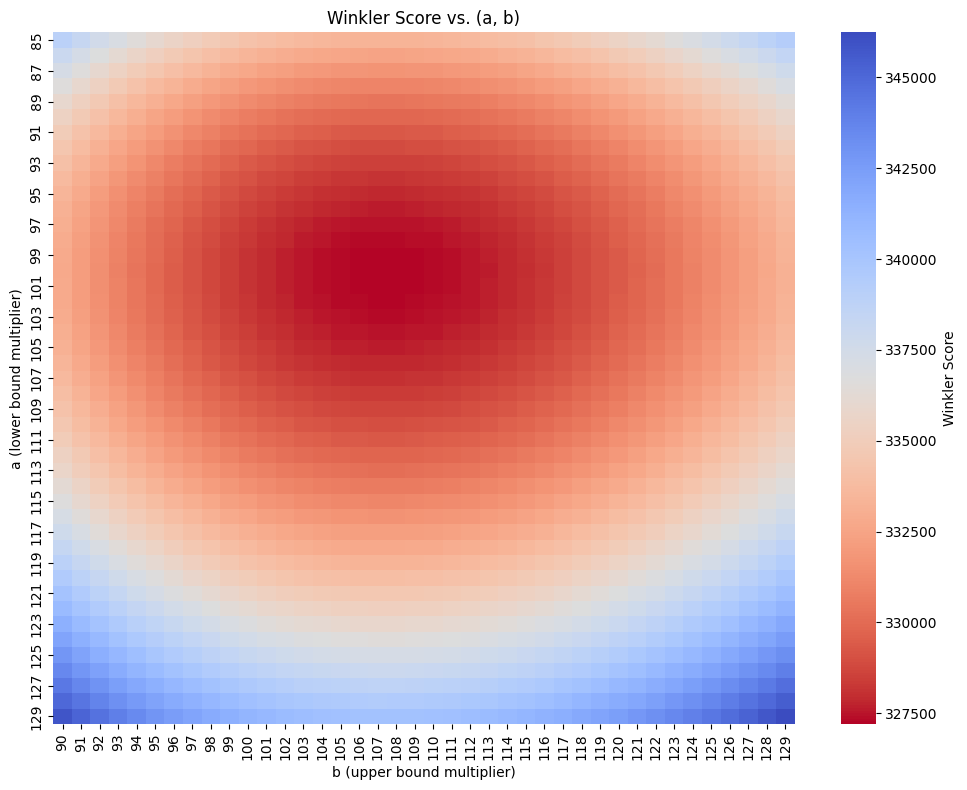

In [20]:
best_a, best_b, best_score, best_coverage, _ = tune_winkler_scaling(
    mean=(oof_preds_lower + oof_preds_upper) / 2,
    std=(oof_preds_upper - oof_preds_lower) / 2,
    true=y,
    alpha=CFG.ALPHA,  # 通常是0.1
    a_range=(85, 130, 1),
    b_range=(90, 130, 1),
    plot=True
)

In [21]:
# --- 4. Final Evaluation and Submission ---
print("\n--- Phase 3: Final Evaluation and Submission ---")

# 对 OOF 做缩放后的分数（可选验证）
scaled_oof_lower = (oof_preds_lower + oof_preds_upper) / 2 - best_a / 100 * (oof_preds_upper - oof_preds_lower) / 2
scaled_oof_upper = (oof_preds_lower + oof_preds_upper) / 2 + best_b / 100 * (oof_preds_upper - oof_preds_lower) / 2
print("Scaled OOF Winkler:", winkler_score_func(y, scaled_oof_lower, scaled_oof_upper))



--- Phase 3: Final Evaluation and Submission ---
Scaled OOF Winkler: 327426.2924125608


In [22]:
test_preds_lower = test_preds_lower_sum / CFG.N_SPLITS
test_preds_upper = test_preds_upper_sum / CFG.N_SPLITS

In [23]:
test_mean = (test_preds_lower + test_preds_upper) / 2
test_std = (test_preds_upper - test_preds_lower) / 2
test_pi_lower = test_mean - best_a / 100 * test_std
test_pi_upper = test_mean + best_b / 100 * test_std

In [24]:
sub = pd.read_csv("/kaggle/input/prediction-interval-competition-ii-house-price/sample_submission.csv")
sub['pi_lower'] = test_pi_lower
sub['pi_upper'] = test_pi_upper
sub.to_csv("submission_scaled.csv", index=False)

In [25]:
df = pd.read_csv("submission_scaled.csv")
print("\nSubmission file 'submission_scaled.csv' has been created.")
print(df.head())


Submission file 'submission_scaled.csv' has been created.
       id       pi_lower      pi_upper
0  200000  794819.210605  1.028225e+06
1  200001  433047.633181  8.346568e+05
2  200002  450733.744493  7.257023e+05
3  200003  288345.392527  4.640733e+05
4  200004  375198.437803  8.353881e+05
